In [1]:
import os 
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../..'
data_dir = os.path.join(base_dir, 'data')
helper_dir = os.path.join(base_dir, 'helper')
output_dir = os.path.join(base_dir, 'output')
png_dir = os.path.join(output_dir, 'png')
os.makedirs(png_dir, exist_ok=True)

In [3]:
# load helper functions
%run {helper_dir}/mk_design_matrix.py
%run {helper_dir}/plot.py
%run {helper_dir}/fit_data.py

## Input

In [4]:
chain = 'Arbitrum'

In [5]:
data_fnames = os.listdir(os.path.join(data_dir, chain)) # names of all data files

# collect the names of the files for this analysis
fnames = dict()
for fname in data_fnames:
    if fname.startswith('Fees'):
        fnames['Fees'] = fname
    if fname.startswith('Volume'):
        fnames['Volume'] = fname
fnames

{'Fees': 'Fees_2021-08-31_2022-07-01.csv',
 'Volume': 'Volume_2021-08-31_2022-07-01.csv'}

In [6]:
# create input-dependent dirs
save_fig_dir = os.path.join(png_dir, chain)
os.makedirs(save_fig_dir, exist_ok=True)

## Prep Data

In [7]:
# read daily data
lst_of_dfs = []
for key, fname in fnames.items():
    # only read the first 7 cols since the last col "Cumulative" is NOT the daily total, but cumulative daily total, 
    # which we don't want.
    df = pd.read_csv(os.path.join(data_dir, chain, fname), 
                     parse_dates=['Date'], index_col='Date', usecols=range(6))
    df.columns = df.columns.str.lower().str.replace(' ', '_') + '_{}'.format(key.lower())
    # calc daily total 
    df['total_{}'.format(key.lower())] = df.sum(axis=1)
    lst_of_dfs.append(df)
del df

df_daily = pd.concat(lst_of_dfs, axis=1)    
df_daily.info()    

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 305 entries, 2021-08-31 to 2022-07-01
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   swap_fees              305 non-null    float64
 1   margin_trading_fees    305 non-null    float64
 2   mint_glp_fees          305 non-null    float64
 3   burn_glp_fees          305 non-null    float64
 4   liquidation_fees       305 non-null    float64
 5   total_fees             305 non-null    float64
 6   swap_volume            305 non-null    float64
 7   margin_trading_volume  305 non-null    float64
 8   mint_glp_volume        305 non-null    float64
 9   burn_glp_volume        305 non-null    float64
 10  liquidation_volume     234 non-null    float64
 11  total_volume           305 non-null    float64
dtypes: float64(12)
memory usage: 31.0 KB


In [8]:
# drop the last row because the most recent date may not be a full day
# drop the first row because nearly no activity on day 1
df_daily = df_daily.iloc[1:-1, :]
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 303 entries, 2021-09-01 to 2022-06-30
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   swap_fees              303 non-null    float64
 1   margin_trading_fees    303 non-null    float64
 2   mint_glp_fees          303 non-null    float64
 3   burn_glp_fees          303 non-null    float64
 4   liquidation_fees       303 non-null    float64
 5   total_fees             303 non-null    float64
 6   swap_volume            303 non-null    float64
 7   margin_trading_volume  303 non-null    float64
 8   mint_glp_volume        303 non-null    float64
 9   burn_glp_volume        303 non-null    float64
 10  liquidation_volume     233 non-null    float64
 11  total_volume           303 non-null    float64
dtypes: float64(12)
memory usage: 30.8 KB


In [9]:
# make linear trend features
X_daily = mk_X_linear_trend(df_daily.index)
X_daily.head()

,trend
Date,
2021-09-01,1.0000
2021-09-02,2.0000
2021-09-03,3.0000
2021-09-04,4.0000
2021-09-05,5.0000


In [10]:
# roll up to weekly level
df_weekly = df_daily.groupby(df_daily.index.to_period('W')).sum()
df_weekly.index.name = 'Week'
df_weekly.head()

,swap_fees,margin_trading_fees,mint_glp_fees,burn_glp_fees,liquidation_fees,total_fees,swap_volume,margin_trading_volume,mint_glp_volume,burn_glp_volume,liquidation_volume,total_volume
Week,,,,,,,,,,,,
2021-08-30/2021-09-05,"3,604.7552","5,523.6847","6,665.1073",134.2987,0.0000,"15,927.8459","1,382,322.3701","5,172,643.6537","2,499,375.6121","954,418.3585",0.0000,"10,008,759.9944"
2021-09-06/2021-09-12,"21,500.0505","74,182.0941","21,870.7486",384.6436,48.1507,"117,985.6876","13,185,796.1989","82,680,227.7865","16,734,506.8532","2,627,679.3987","15,531.7384","115,243,741.9757"
2021-09-13/2021-09-19,"47,729.6157","114,976.3318","43,857.6759","6,188.5673",10.5040,"212,762.6947","13,777,352.0850","120,896,316.0020","23,091,270.5075","8,630,762.2137","8,108.9055","166,403,809.7138"
2021-09-20/2021-09-26,"142,238.4207","314,518.6695","15,758.9545","9,071.1720","3,447.0214","485,034.2381","16,618,636.7943","297,047,791.0733","17,421,672.4453","5,871,677.2325","16,643.7832","336,976,421.3286"
2021-09-27/2021-10-03,"114,062.3772","162,741.8044","21,516.0050","6,561.5159",13.1697,"304,894.8721","16,065,111.0969","141,882,907.4185","9,881,210.9635","6,530,255.6110","2,838.7411","174,362,323.8309"


In [11]:
# make linear trend features for weekly level using 1, ..., nweeks
# this will make the slope of the fitted line measure unit change per week
X_weekly = (np.array(range(len(df_weekly.index))) + 1).reshape(-1,1) 
print(X_weekly.shape)
print(X_weekly[:5, :])

(44, 1)
[[1]
 [2]
 [3]
 [4]
 [5]]


## Fees per $1M Volume

In [12]:
fees_per_milvolume = df_daily.total_fees/df_daily.total_volume * 1e6
fees_per_milvolume.sort_values(ascending=False).head(5)

Date
2022-06-11   4,355.8816
2022-02-18   3,854.8189
2021-11-14   2,874.0840
2022-05-27   2,759.1850
2022-05-05   2,677.5939
dtype: float64

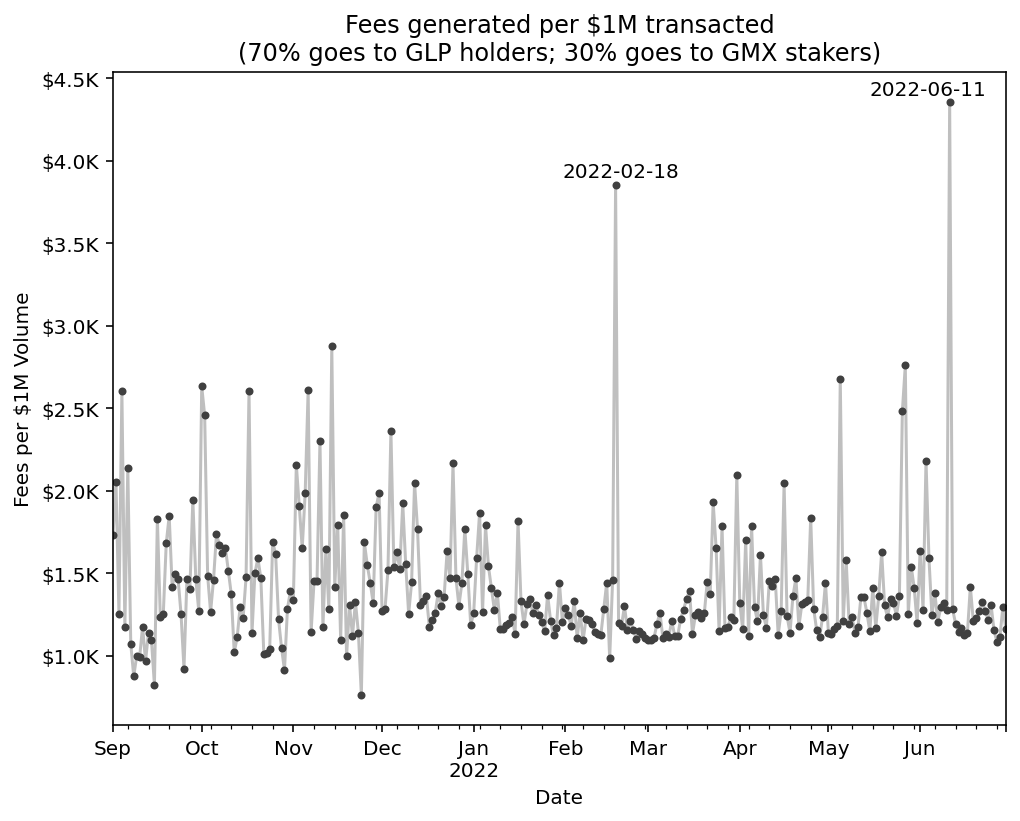

In [13]:
ax = fees_per_milvolume.plot(
    **plot_params, 
    title="Fees generated per $1M transacted\n(70% goes to GLP holders; 30% goes to GMX stakers)",
    ylabel='Fees per $1M Volume')
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=1))
ax.yaxis.set_major_formatter(formatter)
ax.text('2022-05-15', 4.4e3, '2022-06-11')
ax.text('2022-01-31', 3.9e3, '2022-02-18')
plt.savefig(os.path.join(save_fig_dir, 'fees_per_mil_volume.png'), dpi=300);

In [14]:
avg = np.mean(fees_per_milvolume)
ste = st.sem(fees_per_milvolume, ddof=0) # same as std / sqrt(n), do not use the default ddof=1
ci = st.norm.interval(alpha=.95, loc=avg, scale=ste)
print("For every $1M transacted, we can expect, with 95% confidence, the platform to generate between ${:.0f} and ${:.0f} fees.".format(ci[0], ci[1]))
print("Let's take the middle point, ${:.0f}. Then ${:.0f} goes to GLP holders, and ${:.0f} goes to GMX stakers.".format(avg, avg*.7, avg*.3))

For every $1M transacted, we can expect, with 95% confidence, the platform to generate between $1361 and $1452 fees.
Let's take the middle point, $1406. Then $984 goes to GLP holders, and $422 goes to GMX stakers.


## Volume Growth

In [15]:
yvar = 'total_volume'

### Daily

In [16]:
y = df_daily.loc[:, yvar]   # extract target
dd = fit_linreg(X_daily, y) # fit linear trend line, returns a dictionary
yhat = dd['yhat']
slope = dd['slope']

intercept: 57790349.49961131 slope: 370265.55143379926


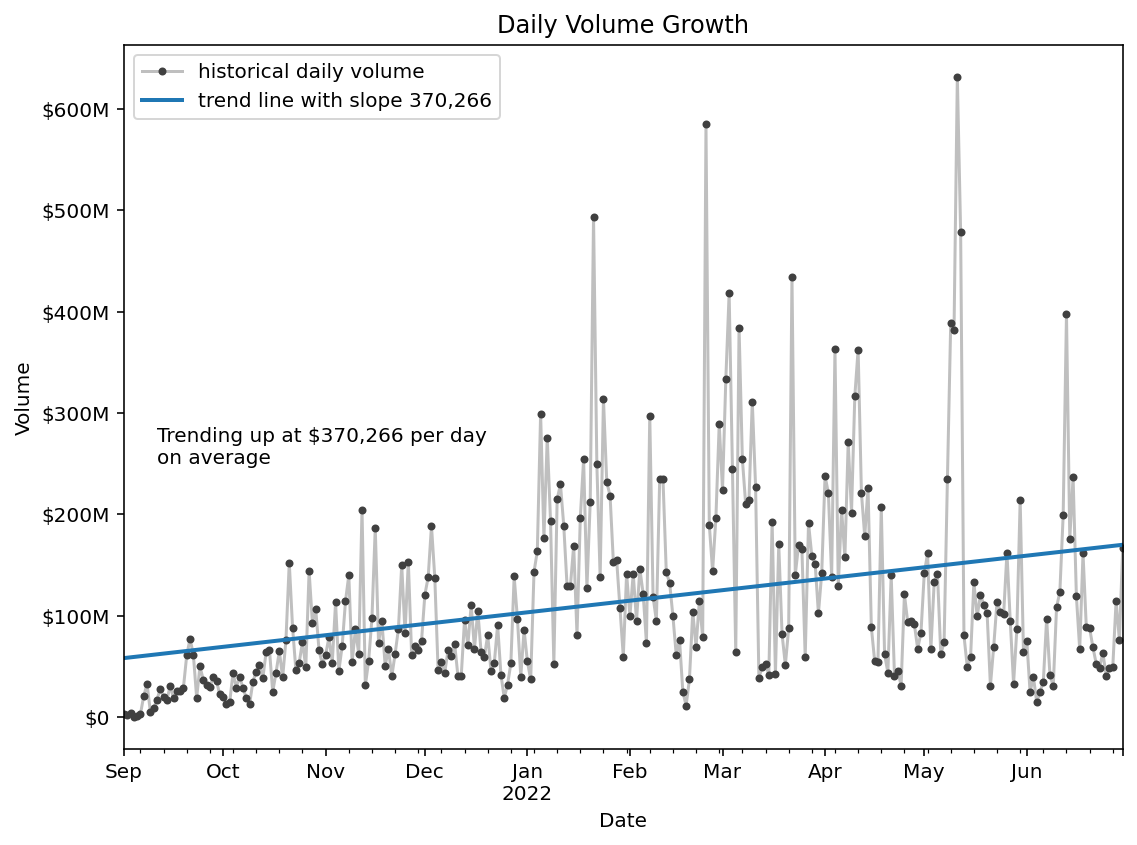

In [17]:
ax = plot_timeseries_with_trendline(
    y, yhat, title='Daily Volume Growth', ylabel='Volume', 
    ytru_legend='historical daily volume', yhat_legend="trend line with slope {:,.0f}".format(slope))
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)
ax.text('2021-09-11', 250e6, "Trending up at ${:,.0f} per day\non average".format(abs(slope)))
plt.tight_layout()
plt.savefig(os.path.join(save_fig_dir, 'daily_volume_growth_trend.png'), dpi=300);

### Weekly

In [18]:
y = df_weekly.loc[:, yvar]   # extract target
dd = fit_linreg(X_weekly, y) # fit linear trend line
yhat = dd['yhat']
slope = dd['slope']

intercept: 399714291.64719886 slope: 17147472.02297024


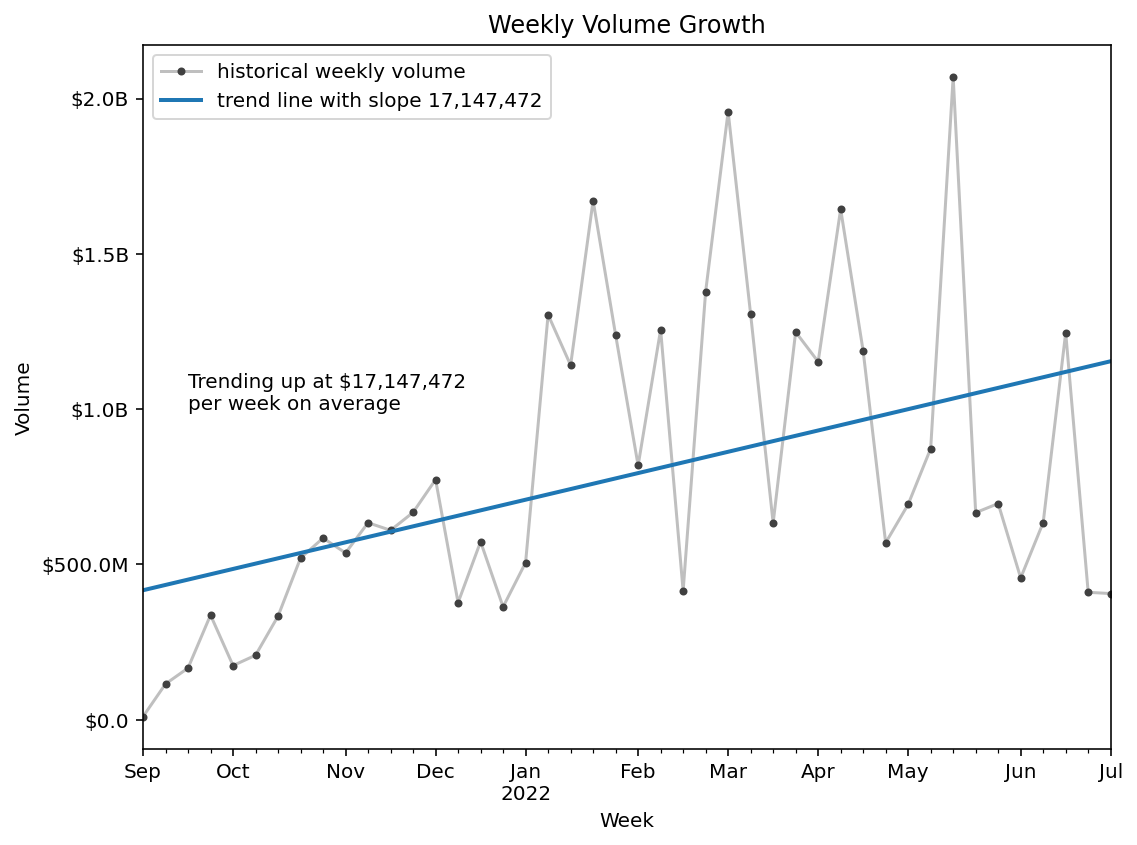

In [19]:
ax = plot_timeseries_with_trendline(
    y, yhat, title='Weekly Volume Growth', ylabel='Volume', 
    ytru_legend='historical weekly volume', yhat_legend="trend line with slope {:,.0f}".format(slope))
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=1))
ax.yaxis.set_major_formatter(formatter)
ax.text('2021-09-15', 1e9, "Trending up at ${:,.0f}\nper week on average".format(abs(slope)))
plt.tight_layout()
plt.savefig(os.path.join(save_fig_dir, 'weekly_volume_growth_trend.png'), dpi=300);

## Fee Growth

In [20]:
yvar = 'total_fees'

### Daily

In [21]:
# extract target
y = df_daily.loc[:, yvar]

# fit linear trend line
dd = fit_linreg(X_daily, y) 
yhat = dd['yhat']
slope = dd['slope']

intercept: 81866.34813494838 slope: 466.6577566763065


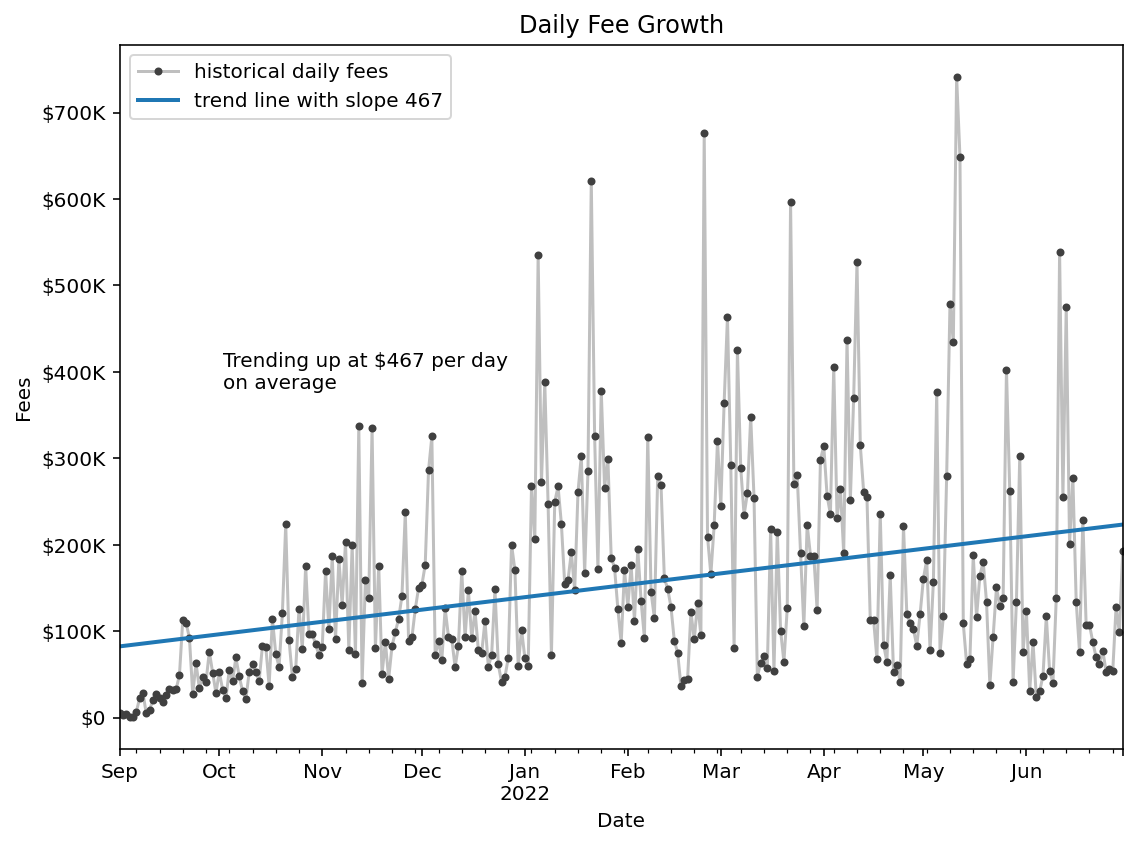

In [22]:
ax = plot_timeseries_with_trendline(
    y, yhat, title='Daily Fee Growth', ylabel='Fees', 
    ytru_legend='historical daily fees', yhat_legend="trend line with slope {:,.0f}".format(slope))
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True))
ax.yaxis.set_major_formatter(formatter)
ax.text('2021-10-02', 380_000, "Trending up at ${:,.0f} per day\non average".format(abs(slope)))
plt.tight_layout()
plt.savefig(os.path.join(save_fig_dir, 'daily_fee_growth_trend.png'), dpi=300);

### Weekly

In [23]:
# extract target
y = df_weekly.loc[:, yvar]

# fit linear trend line
dd = fit_linreg(X_weekly, y) 
yhat = dd['yhat']
slope = dd['slope']

intercept: 566938.4922240889 slope: 21568.282291427713


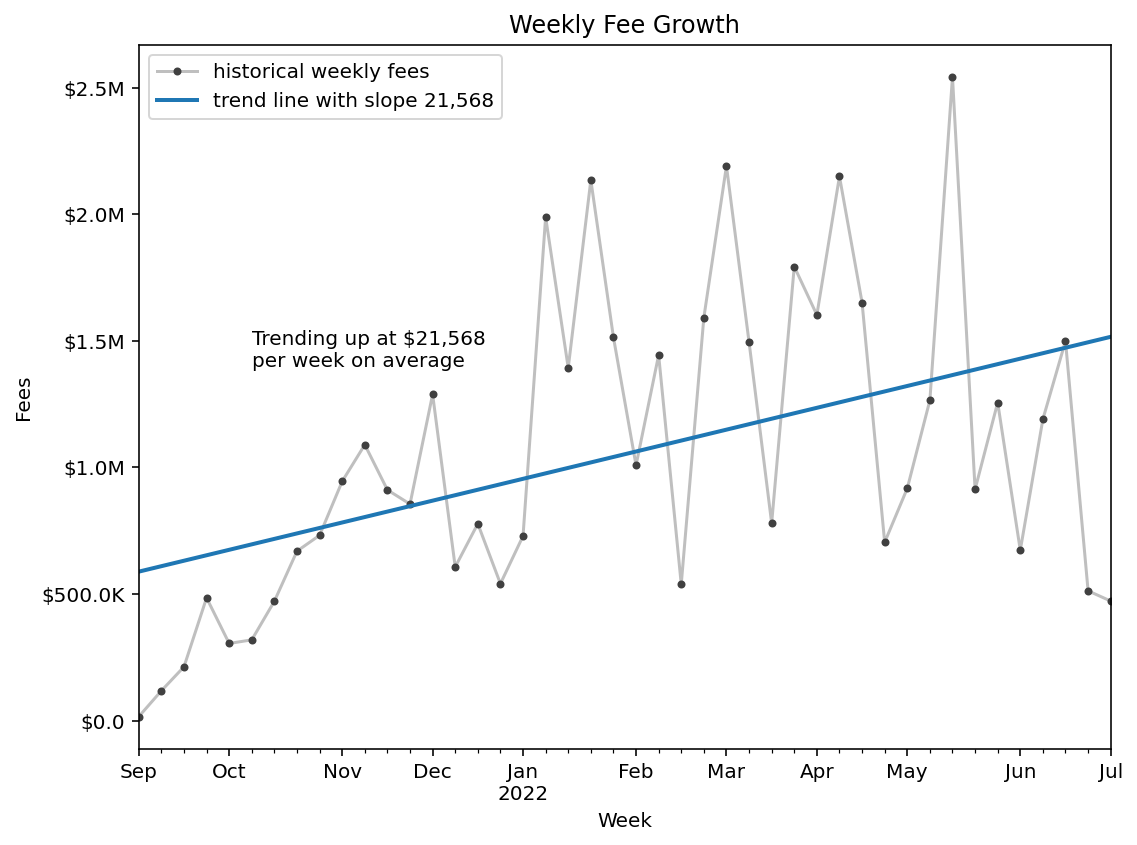

In [24]:
ax = plot_timeseries_with_trendline(
    y, yhat, title='Weekly Fee Growth', ylabel='Fees', 
    ytru_legend='historical weekly fees', yhat_legend="trend line with slope {:,.0f}".format(slope))
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=1))
ax.yaxis.set_major_formatter(formatter)
ax.text('2021-10-10', 1.4e6, "Trending up at ${:,.0f}\nper week on average".format(abs(slope)))
plt.tight_layout()
plt.savefig(os.path.join(save_fig_dir, 'weekly_fee_growth_trend.png'), dpi=300);